In [391]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [392]:
# read csv into df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from constants import *
from glob import glob
from datetime import datetime
import os


df = pd.DataFrame(columns=['datum', "location_id", "pretocnost"])

location_dict = {
    "kum": 0,
    "lovrenška_jezera": 1,
    "osp": 2,
    "storžič": 3,
    "triglavski_narodni_park": 4,
    "vršič": 5,
}

for path in glob(DATA_GLOB_PLANINSKE_MAKRO_ALL):
    print(path)

    # get file name without extension and path
    file_name = os.path.basename(path).split('.')[0].lower().replace(" ", "_")
    if file_name == "zdruzeno":
        continue
    
    # file_name = path.split('/')[-1].split('.')[0].replace(" ", "_").lower()
    assert file_name in location_dict.keys(), f"file_name = {file_name}"
    print(file_name)
    location_id = location_dict[file_name]

    df_planine = pd.read_csv(path, sep=',', encoding='UTF-8')
    assert df_planine.columns[0] == 'datum', f"columns[0] = {df_planine.columns[0]}"
    assert df_planine.columns[1] == 'vhodi', f"columns[1] = {df_planine.columns[1]}"
    assert df_planine.columns[2] == 'izhodi', f"columns[2] = {df_planine.columns[2]}"
    
    # sum vhodi and izhodi
    df_planine['pretocnost'] = df_planine['vhodi'] + df_planine['izhodi']
    # drop "vhodi" and "izhodi" columns
    df_planine = df_planine.drop(columns=['vhodi', 'izhodi'])

    # add "location_id" column
    df_planine['location_id'] = location_id

    df = pd.concat([df, df_planine], ignore_index=True)

    # sum vhodi and izhodi based on "datum_dan"
    # df_planine = df_planine.groupby('datum').sum()
    print(df_planine.head())

    
    # break

df = df.sort_values(by=['datum', 'location_id'])
print(df.head())

df.to_csv(OUT_PLANINSTVO, index=False)



../data/planinstvo/2024\Kum.csv
kum
        datum  pretocnost  location_id
0  2022-06-20           3            0
1  2022-06-21          24            0
2  2022-06-22           3            0
3  2022-06-23           5            0
4  2022-06-24           8            0
../data/planinstvo/2024\Lovrenška jezera.csv
lovrenška_jezera
        datum  pretocnost  location_id
0  2022-06-27         318            1
1  2022-06-28          66            1
2  2022-06-29         214            1
3  2022-06-30         288            1
4  2022-07-01         379            1
../data/planinstvo/2024\Osp.csv
osp
        datum  pretocnost  location_id
0  2022-06-15          46            2
1  2022-06-16          60            2
2  2022-06-17          79            2
3  2022-06-18          62            2
4  2022-06-19          40            2
../data/planinstvo/2024\Storžič.csv
storžič
        datum  pretocnost  location_id
0  2022-07-19          72            3
1  2022-07-20         144            3
2  

## Add day of week to the data

In [393]:
import datetime

# convert datum to day of the week number with Monday=0, Sunday=6
df['datum'] = pd.to_datetime(df['datum'])
df['day_of_week'] = df['datum'].dt.dayofweek

# 

print(df.head())

          datum location_id pretocnost  day_of_week
2251 2022-06-01           4       1288            2
2252 2022-06-02           4        743            3
2253 2022-06-03           4       1128            4
2254 2022-06-04           4       2488            5
2255 2022-06-05           4       2466            6


## Add is holiday to the data

In [394]:
df_prazniki = pd.read_csv(OUT_PRAZNIKI)

# based on datum column from df add "praznik" column from df_prazniki. join based on "datum" column that is only the date without time
df_prazniki['datum'] = pd.to_datetime(df_prazniki['datum'])
df['datum'] = pd.to_datetime(df['datum'])
df_prazniki['datum'] = df_prazniki['datum'].dt.date
df['datum'] = df['datum'].dt.date
df_new = pd.merge(df, df_prazniki, on='datum', how='left') 

# fill NaN values in "dela_prost_dan" column with False
df_new['dela_prost_dan'] = df_new['dela_prost_dan'].fillna(False)

# # set dela_prost_dan to True if day_of_week is 5 or 6
# df_new['dela_prost_dan'] = df_new['dela_prost_dan'] | (df_new['day_of_week'] >= 5)

df_new

,datum,location_id,pretocnost,day_of_week,dela_prost_dan
0,2022-06-01,4,1288,2,False
1,2022-06-02,4,743,3,False
2,2022-06-03,4,1128,4,False
3,2022-06-04,4,2488,5,False
4,2022-06-05,4,2466,6,True
...,...,...,...,...,...
2857,2024-03-29,5,0,4,False
2858,2024-03-30,0,0,5,False
2859,2024-03-30,1,30,5,False
2860,2024-03-30,2,0,5,False


## add vreme columns

In [395]:
df_vreme = pd.read_csv(OUT_VREME)

# rename DATE to datum
df_vreme = df_vreme.rename(columns={'DATE': 'datum'})

# based on datum column from df add "praznik" column from df_vreme. join based on "datum" column that is only the date without time
df_vreme['datum'] = pd.to_datetime(df_vreme['datum'])
df['datum'] = pd.to_datetime(df['datum'])
df_vreme['datum'] = df_vreme['datum'].dt.date
df['datum'] = df['datum'].dt.date
df_new = pd.merge(df, df_vreme, on='datum', how='left') 

# fill NaN values in "dela_prost_dan" column with False
df_new['RR'] = df_new['RR'].fillna(0.0)
df_new['SS'] = df_new['SS'].fillna(0.0)
df_new['TG'] = df_new['TG'].fillna(0.0)

# # set dela_prost_dan to True if day_of_week is 5 or 6
# df_new['dela_prost_dan'] = df_new['dela_prost_dan'] | (df_new['day_of_week'] >= 5)

df_new

,datum,location_id,pretocnost,day_of_week,RR,SS,TG
0,2022-06-01,4,1288,2,0.0,139.0,219.0
1,2022-06-02,4,743,3,18.0,125.0,217.0
2,2022-06-03,4,1128,4,9.0,51.0,214.0
3,2022-06-04,4,2488,5,0.0,141.0,238.0
4,2022-06-05,4,2466,6,0.0,109.0,252.0
...,...,...,...,...,...,...,...
2857,2024-03-29,5,0,4,0.0,0.0,0.0
2858,2024-03-30,0,0,5,0.0,0.0,0.0
2859,2024-03-30,1,30,5,0.0,0.0,0.0
2860,2024-03-30,2,0,5,0.0,0.0,0.0


In [396]:
# sort by "location_id" and "datum"
df_new = df_new.sort_values(by=['location_id', 'datum'])
df_new

,datum,location_id,pretocnost,day_of_week,RR,SS,TG
24,2022-06-20,0,3,0,0.0,140.0,265.0
27,2022-06-21,0,24,1,33.0,102.0,263.0
30,2022-06-22,0,3,2,0.0,60.0,249.0
33,2022-06-23,0,5,3,69.0,69.0,245.0
36,2022-06-24,0,8,4,9.0,104.0,245.0
...,...,...,...,...,...,...,...
2845,2024-03-26,5,0,1,0.0,0.0,0.0
2849,2024-03-27,5,0,2,0.0,0.0,0.0
2853,2024-03-28,5,0,3,0.0,0.0,0.0
2857,2024-03-29,5,0,4,0.0,0.0,0.0


In [397]:
# add month column
df_new['month'] = pd.to_datetime(df_new['datum']).dt.month
df_new

,datum,location_id,pretocnost,day_of_week,RR,SS,TG,month
24,2022-06-20,0,3,0,0.0,140.0,265.0,6
27,2022-06-21,0,24,1,33.0,102.0,263.0,6
30,2022-06-22,0,3,2,0.0,60.0,249.0,6
33,2022-06-23,0,5,3,69.0,69.0,245.0,6
36,2022-06-24,0,8,4,9.0,104.0,245.0,6
...,...,...,...,...,...,...,...,...
2845,2024-03-26,5,0,1,0.0,0.0,0.0,3
2849,2024-03-27,5,0,2,0.0,0.0,0.0,3
2853,2024-03-28,5,0,3,0.0,0.0,0.0,3
2857,2024-03-29,5,0,4,0.0,0.0,0.0,3


In [398]:
# todo: add moving average by date for each location separately
df_new['pretocnost_7d'] = df_new.groupby('location_id')['pretocnost'].transform(lambda x: x.rolling(7, 1).mean())

df_new['pretocnost_3d'] = df_new.groupby('location_id')['pretocnost'].transform(lambda x: x.rolling(3, 1).mean())


In [399]:
# check if nan values are present in "pretocnost" column
df_new[df_new['pretocnost'].isnull()]

# make quantiles 3 bins group_by "location_id"
for location_id in df_new['location_id'].unique():
    num_quantiles = 3
    # get [.33, .66]
    quantile_list = [i/num_quantiles for i in range(1, num_quantiles)]
    # print(quantile_list)
    quantiles = df_new[df_new['location_id'] == location_id]['pretocnost'].quantile(quantile_list)
    bins = [-np.inf] + quantiles.to_list() + [np.inf]
    # print(bins)

    # cut based on quantiles
    df_new.loc[df_new['location_id'] == location_id, 'pretocnost_q'] = pd.cut(df_new[df_new['location_id'] == location_id]['pretocnost'], bins=bins, labels=False)

df_new['pretocnost_q'] = df_new['pretocnost_q'].astype(int)

# # drop pretocnost column
df_new = df_new.drop(columns=['pretocnost'])
df_new

,datum,location_id,day_of_week,RR,SS,TG,month,pretocnost_7d,pretocnost_3d,pretocnost_q
24,2022-06-20,0,0,0.0,140.0,265.0,6,3.00,3.000000,0
27,2022-06-21,0,1,33.0,102.0,263.0,6,13.50,13.500000,1
30,2022-06-22,0,2,0.0,60.0,249.0,6,10.00,10.000000,0
33,2022-06-23,0,3,69.0,69.0,245.0,6,8.75,10.666667,0
36,2022-06-24,0,4,9.0,104.0,245.0,6,8.60,5.333333,1
...,...,...,...,...,...,...,...,...,...,...
2845,2024-03-26,5,1,0.0,0.0,0.0,3,0.00,0.000000,0
2849,2024-03-27,5,2,0.0,0.0,0.0,3,0.00,0.000000,0
2853,2024-03-28,5,3,0.0,0.0,0.0,3,0.00,0.000000,0
2857,2024-03-29,5,4,0.0,0.0,0.0,3,0.00,0.000000,0


In [400]:
# save to csv
df_new.to_csv(OUT_PLANINSTVO_END, index=False)


In [405]:
# split data to train (2022 and 2023) and test (2024)
df_train = df_new[df_new['datum'] < datetime.date(2024, 1, 1)]
df_test = df_new[df_new['datum'] >= datetime.date(2024, 1, 1)]

df_train

#split train on train and validation 80/20 split
# train_df, val_df = df_train(df_train, test_size=0.2, random_state=42)


,datum,location_id,day_of_week,RR,SS,TG,month,pretocnost_7d,pretocnost_3d,pretocnost_q
24,2022-06-20,0,0,0.0,140.0,265.0,6,3.000000,3.000000,0
27,2022-06-21,0,1,33.0,102.0,263.0,6,13.500000,13.500000,1
30,2022-06-22,0,2,0.0,60.0,249.0,6,10.000000,10.000000,0
33,2022-06-23,0,3,69.0,69.0,245.0,6,8.750000,10.666667,0
36,2022-06-24,0,4,9.0,104.0,245.0,6,8.600000,5.333333,1
...,...,...,...,...,...,...,...,...,...,...
2528,2023-12-27,5,2,0.0,0.0,0.0,12,38.285714,48.000000,0
2532,2023-12-28,5,3,0.0,0.0,102.0,12,34.571429,30.000000,0
2536,2023-12-29,5,4,0.0,0.0,76.0,12,38.000000,10.666667,0
2540,2023-12-30,5,5,0.0,0.0,0.0,12,33.714286,19.666667,1


In [402]:
# remove "datum" column
df_train = df_train.drop(columns=['datum'])


In [403]:
# start training a model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

X = df_train.drop(columns=['pretocnost_q'])
y = df_train['pretocnost_q']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

# print y_pred and y_val in dataframe
df_pred = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
# add X_val columns
df_pred = pd.concat([df_pred, X_val], axis=1)

mse = mean_squared_error(y_val, y_pred)
print(f"mse = {mse}")

# accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"accuracy = {accuracy}")

# precision and recall and f1 summary
print(classification_report(y_val, y_pred))

# print all wrong predictions
print("Number of wrong predictions: ", len(df_pred[df_pred['y_val'] != df_pred['y_pred']]))
print("Number of correct predictions: ", len(df_pred[df_pred['y_val'] == df_pred['y_pred']]))

df_pred[df_pred['y_val'] != df_pred['y_pred']]

# # save model
# import joblib
# joblib.dump(model, OUT_MODEL)


mse = 0.29862475442043224
accuracy = 0.7544204322200393
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       130
           1       0.67      0.66      0.66       175
           2       0.83      0.84      0.83       204

    accuracy                           0.75       509
   macro avg       0.75      0.75      0.75       509
weighted avg       0.75      0.75      0.75       509

Number of wrong predictions:  125
Number of correct predictions:  384


,y_val,y_pred,location_id,day_of_week,RR,SS,TG,month,pretocnost_7d,pretocnost_3d
322,2,1,1,4,96.0,45.0,218.0,8,1282.714286,679.000000
1805,0,1,3,3,234.0,84.0,227.0,8,70.285714,28.333333
708,1,0,3,5,304.0,0.0,145.0,10,83.714286,18.666667
2172,1,2,0,0,0.0,0.0,0.0,10,329.571429,494.333333
2039,0,1,2,1,6.0,49.0,189.0,9,28.714286,22.000000
...,...,...,...,...,...,...,...,...,...,...
382,1,2,1,0,0.0,66.0,215.0,8,374.000000,408.000000
437,2,1,2,2,0.0,95.0,236.0,9,56.857143,60.333333
2359,0,1,2,2,0.0,0.0,0.0,11,113.142857,14.666667
2334,2,1,2,4,0.0,0.0,0.0,11,103.428571,61.666667


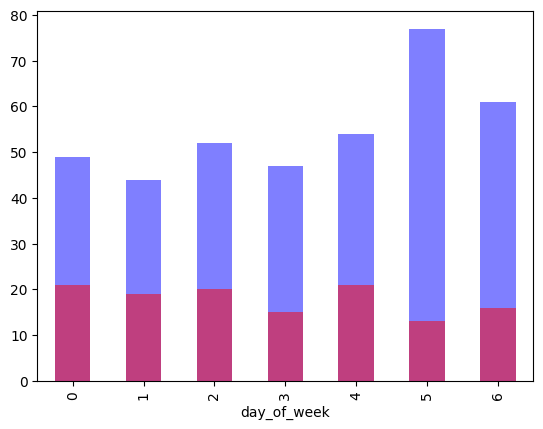

KeyError: 'dela_prost_dan'

In [404]:
# visualize correct vs wrong predictions based on day_of_week
df_pred['correct'] = df_pred['y_val'] == df_pred['y_pred']
df_pred['wrong'] = df_pred['y_val'] != df_pred['y_pred']

df_pred.groupby('day_of_week')['correct'].sum().plot(kind='bar', color='blue', alpha=0.5)
df_pred.groupby('day_of_week')['wrong'].sum().plot(kind='bar', color='red', alpha=0.5)
plt.show()

# do the same for dela_prost_dan
df_pred.groupby('dela_prost_dan')['correct'].sum().plot(kind='bar', color='blue', alpha=0.5)
df_pred.groupby('dela_prost_dan')['wrong'].sum().plot(kind='bar', color='red', alpha=0.5)
plt.show()

In [ ]:
# get correlation matrix
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,location_id,day_of_week,dela_prost_dan,month,pretocnost_7d,pretocnost_3d,pretocnost_q
location_id,1.000000,0.003618,-0.022804,0.225825,0.173762,0.157364,0.020253
day_of_week,0.003618,1.000000,-0.087877,0.015142,0.000262,0.004847,0.224034
dela_prost_dan,-0.022804,-0.087877,1.000000,-0.018575,0.005918,0.008295,0.107357
month,0.225825,0.015142,-0.018575,1.000000,0.012265,0.010051,-0.088852
pretocnost_7d,0.173762,0.000262,0.005918,0.012265,1.000000,0.904133,0.122686
pretocnost_3d,0.157364,0.004847,0.008295,0.010051,0.904133,1.000000,0.138674
pretocnost_q,0.020253,0.224034,0.107357,-0.088852,0.122686,0.138674,1.000000


In [ ]:
# %pip install Jinja2